# CVE.ICU - Predictions
---

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  If you have any questions or suggestions, please join the [discussion here](https://github.com/jgamblin/cve.icu/discussions) and check out the [source code](https://github.com/jgamblin/cve.icu/).  Questions? Reach out to [@jgamblin](https://www.twitter.com/jgamblin).

**Year Data**
-  [All](Index.html)
-  [2021](2021.html)
-  [2020](2020.html)
-  [2019](2019.html)
-  [CVE Growth Predictions](predictions.htnl)

In [2]:
import datetime
import glob
import json
import logging
import sys
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
logging.disable(sys.maxsize)

In [3]:
row_accumulator = []
for filename in glob.glob('*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)

CVEs from NVD: 71987
CVEs Published Per Publishing Day: 46.0


## Predictions

In [ ]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day}**")

In [4]:
cve_day = pd.DataFrame(nvd.Published.value_counts().reset_index().values, columns=["ds", "y"]);
cve_day = cve_day.sort_index(axis = 0, ascending=True);
cve_day = cve_day[cve_day['y'] <= 400]; 

,ds,y
2,2019-12-18,362
3,2018-02-15,315
4,2017-08-08,310
5,2019-09-27,309
6,2020-03-12,306
7,2018-06-11,303
8,2021-04-22,295
9,2020-07-15,278
10,2018-10-17,261
11,2019-03-21,255


In [5]:
m = Prophet();
m.fit(cve_day);
future = m.make_future_dataframe(periods=3650);

### Prediction Per Year

In [ ]:
forecast = m.predict(future)
by_year = forecast.copy()
result = by_year.groupby(by_year.ds.dt.to_period("Y"))['yhat'].sum().round()

for year, records in result.items():
    print(f"{year} - {records} CVEs")

### Plot the Forecast

This shows the plot for all previous data and the next 10 years. 

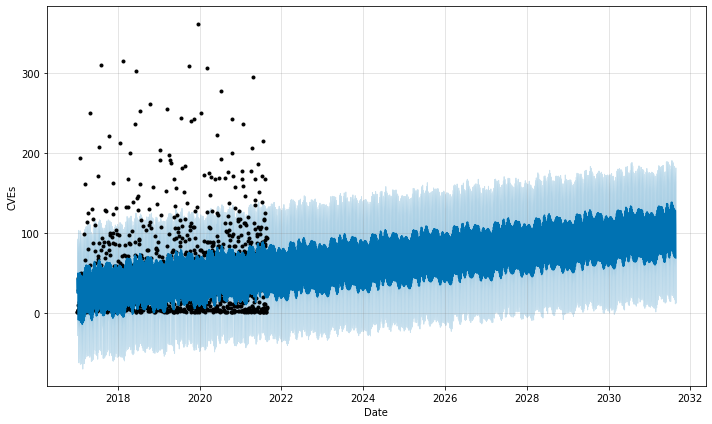

In [6]:

fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8) )

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

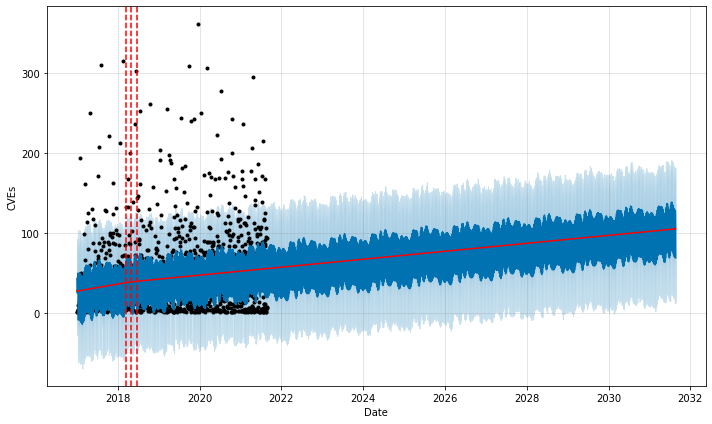

In [7]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Most CVE Per Day Predictions For The Next Year

In [8]:
date_now = datetime.now()
one_year = date_now + pd.DateOffset(years=1)
five_year = date_now + pd.DateOffset(years=5)
ten_year = date_now + pd.DateOffset(years=10)


cve_prophet_thisyear = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < one_year)]
cve_prophet_thisyear =  cve_prophet_thisyear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_thisyear

,ds,yhat,yhat_lower,yhat_upper
1607,2021-10-06,85.0,33.0,137.0
1600,2021-09-29,85.0,35.0,137.0
1593,2021-09-22,85.0,31.0,133.0
1621,2021-10-20,84.0,30.0,138.0
1614,2021-10-13,84.0,33.0,136.0
1628,2021-10-27,84.0,32.0,139.0
1586,2021-09-15,83.0,28.0,132.0
1670,2021-12-08,81.0,30.0,134.0
1677,2021-12-15,81.0,31.0,131.0
1635,2021-11-03,81.0,29.0,132.0


### Most CVE Per Day Predictions For The Next 5 Years

In [9]:
cve_prophet_next5 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < five_year)]
cve_prophet_next5 = cve_prophet_next5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next5

,ds,yhat,yhat_lower,yhat_upper
3357,2026-07-22,114.0,61.0,166.0
3350,2026-07-15,113.0,63.0,168.0
3315,2026-06-10,112.0,59.0,163.0
3308,2026-06-03,111.0,62.0,160.0
3427,2026-09-30,110.0,59.0,162.0
3420,2026-09-23,110.0,53.0,159.0
3364,2026-07-29,110.0,61.0,159.0
2986,2025-07-16,109.0,55.0,158.0
3441,2026-10-14,109.0,54.0,161.0
3434,2026-10-07,109.0,58.0,159.0


### Most CVE Per Day Predictions For The Next 10 Years

In [10]:
cve_prophet_next10 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < ten_year)]
cve_prophet_next10 = cve_prophet_next10[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next10

,ds,yhat,yhat_lower,yhat_upper
5177,2031-07-16,138.0,86.0,191.0
5184,2031-07-23,138.0,83.0,186.0
5135,2031-06-04,137.0,84.0,190.0
5142,2031-06-11,136.0,80.0,189.0
5191,2031-07-30,135.0,85.0,187.0
5170,2031-07-09,134.0,81.0,184.0
5065,2031-03-26,134.0,82.0,184.0
4813,2030-07-17,134.0,79.0,188.0
4820,2030-07-24,133.0,80.0,189.0
5093,2031-04-23,133.0,80.0,185.0
